# Algo Trading with SAR Indicator

https://blog.quantinsti.com/parabolic-sar/

https://blog.quantinsti.com/install-ta-lib-python/

In [147]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import talib
from statistics import mean 

In [264]:
# Import data from yahoo finance
data = yf.download(tickers='MSFT', start='2018-01-01', end='2021-1-30')
# Drop the NaN values
data = data.dropna()
data.tail()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-25,229.12,229.78,224.22,229.53,229.53,33152100
2021-01-26,231.86,234.18,230.08,232.33,232.33,49169600
2021-01-27,238.00,240.44,230.14,232.90,232.90,69870600
2021-01-28,235.61,242.64,235.09,238.93,238.93,49111200
2021-01-29,235.99,238.02,231.35,231.96,231.96,42468900


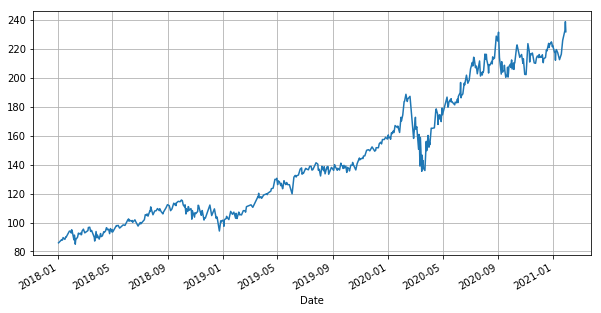

In [265]:
plt.style.use('fast')
data.Close.plot(figsize=(10,5))
plt.grid()
plt.show()

In [266]:
# Calculate parabolic sar
data['SAR'] = talib.SAR(data.High, data.Low, acceleration=0.02, maximum=0.2)

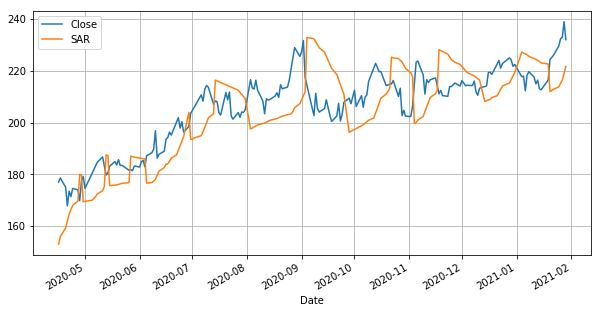

In [267]:
# Plot Parabolic SAR with close price
data[['Close', 'SAR']][-200:].plot(figsize=(10,5))
plt.grid()
plt.show()

In [268]:
# Calculate Tenkan-sen
high_9 = data.High.rolling(9).max()
low_9 = data.Low.rolling(9).min()
data['tenkan_sen_line'] = (high_9 + low_9) /2

# Calculate Kijun-sen
high_26 = data.High.rolling(26).max()
low_26 = data.Low.rolling(26).min()
data['kijun_sen_line'] = (high_26 + low_26) / 2

# Calculate Senkou Span A
data['senkou_spna_A'] = ((data.tenkan_sen_line + data.kijun_sen_line) / 2).shift(26)

# Calculate Senkou Span B
high_52 = data.High.rolling(52).max()
low_52 = data.High.rolling(52).min()
data['senkou_spna_B'] = ((high_52 + low_52) / 2).shift(26)

# Calculate Chikou Span B
data['chikou_span'] = data.Close.shift(-26)

In [269]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,SAR,tenkan_sen_line,kijun_sen_line,senkou_spna_A,senkou_spna_B,chikou_span
Date,,,,,,,,,,,,
2018-01-02,86.13,86.31,85.50,85.95,82.38,22483800,NaN,NaN,NaN,NaN,NaN,85.01
2018-01-03,86.06,86.51,85.97,86.35,82.77,26061400,85.500000,NaN,NaN,NaN,NaN,88.18
2018-01-04,86.59,87.66,86.57,87.11,83.50,21912000,85.520200,NaN,NaN,NaN,NaN,89.13
2018-01-05,87.66,88.41,87.43,88.19,84.53,23407100,85.605792,NaN,NaN,NaN,NaN,89.83
2018-01-08,88.20,88.58,87.60,88.28,84.62,22113000,85.774044,NaN,NaN,NaN,NaN,90.81


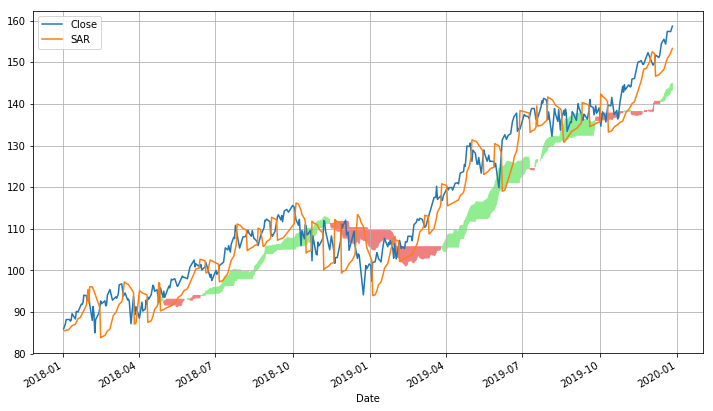

In [270]:
# Plot closing price and parabolic SAR
komu_cloud = data[['Close','SAR']][:500].plot(figsize=(12, 7))

# Plot Komu cloud
komu_cloud.fill_between(data.index[:500], data.senkou_spna_A[:500], data.senkou_spna_B[:500],
 where=data.senkou_spna_A[:500] >= data.senkou_spna_B[:500], color='lightgreen')
komu_cloud.fill_between(data.index[:500], data.senkou_spna_A[:500], data.senkou_spna_B[:500],
 where=data.senkou_spna_A[:500] < data.senkou_spna_B[:500], color='lightcoral')

plt.grid()
plt.legend()
plt.show()

In [271]:
# Buy Signal
data['signal'] = 0
#data.loc[(data.Close > data.senkou_spna_A) & (data.Close >
#data.senkou_spna_B) & (data.Close > data.SAR), 'signal'] = 1

data.loc[(data.Close > data.SAR), 'signal'] = 1

# Sell Signal
#data.loc[(data.Close < data.senkou_spna_A) & (data.Close <
 #data.senkou_spna_B) & (data.Close < data.SAR), 'signal'] = -1

data.loc[(data.Close < data.SAR), 'signal'] = -1

In [272]:
data['signal'].value_counts()

 1    500
-1    274
 0      1
Name: signal, dtype: int64

In [273]:
# Calculate daily returns
daily_returns = data.Close.pct_change()
# Calculate strategy returns
strategy_returns = daily_returns *data['signal'].shift(1)

In [274]:
strategy_returns

Date
2018-01-02         NaN
2018-01-03    0.000000
2018-01-04    0.008801
2018-01-05    0.012398
2018-01-08    0.001021
                ...   
2021-01-25    0.015844
2021-01-26    0.012199
2021-01-27    0.002453
2021-01-28    0.025891
2021-01-29   -0.029172
Length: 775, dtype: float64

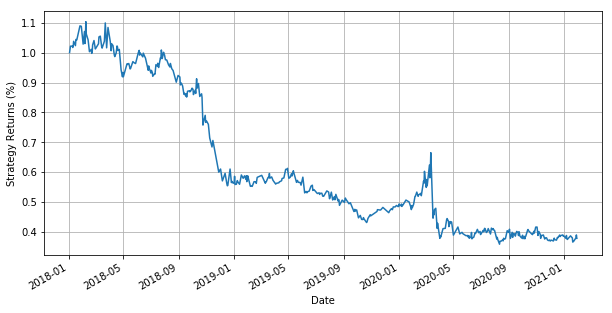

In [275]:
# Calculate cumulative returns
(strategy_returns+1).cumprod().plot(figsize=(10,5))
# Plot the strategy returns
plt.xlabel('Date')
plt.ylabel('Strategy Returns (%)')
plt.grid()
plt.show()

In [276]:
data.head(20)

,Open,High,Low,Close,Adj Close,Volume,SAR,tenkan_sen_line,kijun_sen_line,senkou_spna_A,senkou_spna_B,chikou_span,signal
Date,,,,,,,,,,,,,
2018-01-02,86.13,86.31,85.50,85.95,82.38,22483800,NaN,NaN,NaN,NaN,NaN,85.01,0
2018-01-03,86.06,86.51,85.97,86.35,82.77,26061400,85.500000,NaN,NaN,NaN,NaN,88.18,1
2018-01-04,86.59,87.66,86.57,87.11,83.50,21912000,85.520200,NaN,NaN,NaN,NaN,89.13,1
2018-01-05,87.66,88.41,87.43,88.19,84.53,23407100,85.605792,NaN,NaN,NaN,NaN,89.83,1
2018-01-08,88.20,88.58,87.60,88.28,84.62,22113000,85.774044,NaN,NaN,NaN,NaN,90.81,1
2018-01-09,88.65,88.73,87.86,88.22,84.56,19484300,85.998521,NaN,NaN,NaN,NaN,92.66,1
2018-01-10,87.86,88.19,87.41,87.82,84.18,18652200,86.271669,NaN,NaN,NaN,NaN,92.00,1
2018-01-11,88.13,88.13,87.24,88.08,84.43,17808900,86.517502,NaN,NaN,NaN,NaN,92.72,1
2018-01-12,88.67,89.78,88.45,89.60,85.88,24271500,86.738752,87.640,NaN,NaN,NaN,91.49,1


In [277]:
dates = []
returns = []
avgGains = []

buyPoint = 0
startingCapital = 5000
cash = startingCapital

sharesHeld = 0
amountInStocks = 0

prevSignal = 0

for row in data.iterrows():
    
    signal = row[-1][-1]
    close = float(row[1][4])
    
    if signal == 1 and (prevSignal == 0 or prevSignal == -1): 
        
        sharesHeld = cash // close
        amountHeld = close * sharesHeld
        cash = cash - amountHeld
        
        buyPoint = close
        
        print('BUY', str(row[0])[0 : 12], close, sharesHeld, close * sharesHeld, cash)
        print()
        
        prevSignal = 1
     
    if signal == -1 and prevSignal == 1:
        
        cash += sharesHeld * close
        
        avgGains.append((close - buyPoint) / buyPoint * 100)
        
        print('SELL', str(row[0])[0 : 12], close, sharesHeld, sharesHeld * close, cash)
        print()
        
        sharesHeld = 0
        prevSignal = 0
        buyPoint = 0
    
    
    
    returns.append((sharesHeld * close) + cash)
    dates.append(row[0])
    
    #print(row, '*****' + str(row[0]))
    #print()
    #print(row[0], round(cash, 2), signal)
    #print()
    #print(signal)

BUY 2018-01-03 0 82.77 60.0 4966.2 33.80000000000018

SELL 2018-01-30 0 88.89 60.0 5333.4 5367.2

BUY 2018-02-01 0 90.35 59.0 5330.65 36.55000000000018

SELL 2018-02-02 0 87.97 59.0 5190.23 5226.78

BUY 2018-02-15 0 89.23 58.0 5175.34 51.4399999999996

SELL 2018-03-14 0 90.38 58.0 5242.04 5293.48

BUY 2018-03-27 0 86.16 61.0 5255.76 37.719999999999345

SELL 2018-04-02 0 85.25 61.0 5200.25 5237.969999999999

BUY 2018-04-12 0 90.12 58.0 5226.96 11.009999999999309

SELL 2018-04-25 0 88.9 58.0 5156.200000000001 5167.21

BUY 2018-04-27 0 92.28 55.0 5075.4 91.8100000000004

SELL 2018-06-13 0 97.54 55.0 5364.700000000001 5456.510000000001

BUY 2018-06-20 0 98.53 55.0 5419.15 37.36000000000149

SELL 2018-06-25 0 95.16 55.0 5233.8 5271.160000000002

BUY 2018-07-06 0 97.84 53.0 5185.52 85.64000000000124

SELL 2018-07-27 0 104.15 53.0 5519.950000000001 5605.590000000002

BUY 2018-08-08 0 105.9 52.0 5506.8 98.79000000000178

SELL 2018-08-21 0 102.9 52.0 5350.8 5449.590000000002

BUY 2018-08-27 0 1

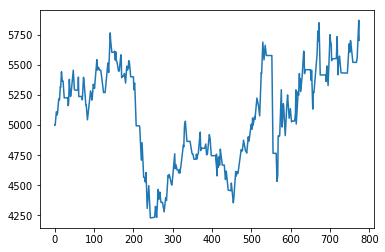

In [278]:
plt.plot(returns)

Avg Gain 0.39580196046373767
19 19
14.091000000000022 181.57319737800438


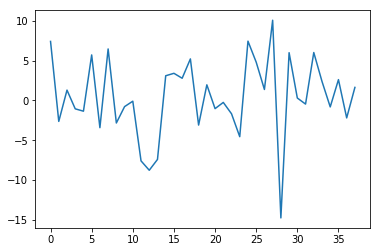

In [279]:
plt.plot(avgGains)
print('Avg Gain', mean(avgGains))

posCount = len(list(filter(lambda x: (x >= 0), avgGains)))
negCount = len(list(filter(lambda x: (x < 0), avgGains))) 

print(posCount, negCount)

stockReturn = (data['Adj Close'][-1] - data['Adj Close'][0]) / data['Adj Close'][0] * 100
stratReturn = (returns[-1] - startingCapital) / startingCapital * 100

print(stratReturn, stockReturn)